# 1. Import libraries

In [1]:
#----------------------------Reproducible----------------------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
import random as rn
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)

np.random.seed(seed)
rn.seed(seed)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf =tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

#tf.set_random_seed(seed)
tf.compat.v1.set_random_seed(seed)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)
#----------------------------Reproducible----------------------------------------------------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#--------------------------------------------------------------------------------------------------------------------------------
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Activation, Dropout, Layer
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import optimizers,initializers,constraints,regularizers
from keras import backend as K
from keras.callbacks import LambdaCallback,ModelCheckpoint
from keras.utils import plot_model

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import h5py
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pandas as pd
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches
import matplotlib as mpl

#--------------------------------------------------------------------------------------------------------------------------------
#Import ourslef defined methods
import sys
sys.path.append(r"./Defined")
import Functions as F

# The following code should be added before the keras model
#np.random.seed(seed)

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# 2. Loading data

In [2]:
xy_test = np.load('bgedv2_XY_te_float32.npy')
print('Shape of xy_test: ' + str(xy_test.shape))

Shape of xy_test: (11101, 10463)


In [3]:
key_feture_number=943

# 3.Model

In [4]:
np.random.seed(seed)

#--------------------------------------------------------------------------------------------------------------------------------
class Feature_Select_Layer(Layer):
    
    def __init__(self, output_dim, l1_lambda, **kwargs):
        super(Feature_Select_Layer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.l1_lambda=l1_lambda

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',  
                                      shape=(input_shape[1],),
                                      initializer=initializers.RandomUniform(minval=0.999999, maxval=0.9999999, seed=seed),
                                      trainable=True,
                                      regularizer=regularizers.l1(self.l1_lambda),
                                      constraint=constraints.NonNeg())
        super(Feature_Select_Layer, self).build(input_shape)
    
    def call(self, x, selection=False,k=key_feture_number):
        kernel=self.kernel        
        if selection:
            kernel_=K.transpose(kernel)
            kth_largest = tf.math.top_k(kernel_, k=k)[0][-1]
            kernel = tf.where(condition=K.less(kernel,kth_largest),x=K.zeros_like(kernel),y=kernel)        
        return K.dot(x, tf.linalg.tensor_diag(kernel))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

#--------------------------------------------------------------------------------------------------------------------------------
def Autoencoder(p_data_feature=xy_test.shape[1],\
                p_encoding_dim=key_feture_number,\
                p_learning_rate= 1E-3):
    input_img = Input(shape=(p_data_feature,), name='input_img')

    encoded = Dense(p_encoding_dim, activation='linear',kernel_initializer=initializers.glorot_uniform(seed))(input_img)
    bottleneck=encoded
    decoded = Dense(p_data_feature, activation='linear',kernel_initializer=initializers.glorot_uniform(seed))(encoded)

    latent_encoder = Model(input_img, bottleneck)
    autoencoder = Model(input_img, decoded)
    
    autoencoder.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    #print('Latent Encoder Structure-------------------------------------')
    #latent_encoder.summary()
    return autoencoder,latent_encoder

#--------------------------------------------------------------------------------------------------------------------------------
def Identity_Autoencoder(p_data_feature=xy_test.shape[1],\
                         p_encoding_dim=key_feture_number,\
                         p_learning_rate= 1E-3,\
                         p_l1_lambda=0.1):
    
    input_img = Input(shape=(p_data_feature,), name='autoencoder_input')

    feature_selection = Feature_Select_Layer(output_dim=p_data_feature,\
                                             l1_lambda=p_l1_lambda,\
                                             input_shape=(p_data_feature,),\
                                             name='feature_selection')

    feature_selection_score=feature_selection(input_img)

    encoded = Dense(p_encoding_dim,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_hidden_layer')
    
    encoded_score=encoded(feature_selection_score)
    
    bottleneck_score=encoded_score
    
    decoded = Dense(p_data_feature,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_output')
    
    decoded_score =decoded(bottleneck_score)

    latent_encoder_score = Model(input_img, bottleneck_score)
    autoencoder = Model(input_img, decoded_score)
    
    autoencoder.compile(loss='mean_squared_error',\
                        optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    return autoencoder,latent_encoder_score

#--------------------------------------------------------------------------------------------------------------------------------
def Fractal_Autoencoder(p_data_feature=xy_test.shape[1],\
                        p_feture_number=key_feture_number,\
                        p_encoding_dim=key_feture_number,\
                        p_learning_rate=1E-3,\
                        p_l1_lambda=0.1,\
                        p_loss_weight_1=1,\
                        p_loss_weight_2=2):
    
    input_img = Input(shape=(p_data_feature,), name='autoencoder_input')

    feature_selection = Feature_Select_Layer(output_dim=p_data_feature,\
                                             l1_lambda=p_l1_lambda,\
                                             input_shape=(p_data_feature,),\
                                             name='feature_selection')

    feature_selection_score=feature_selection(input_img)
    feature_selection_choose=feature_selection(input_img,selection=True,k=p_feture_number)

    encoded = Dense(p_encoding_dim,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_hidden_layer')
    
    encoded_score=encoded(feature_selection_score)
    encoded_choose=encoded(feature_selection_choose)
    
    bottleneck_score=encoded_score
    bottleneck_choose=encoded_choose
    
    decoded = Dense(p_data_feature,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_output')
    
    decoded_score =decoded(bottleneck_score)
    decoded_choose =decoded(bottleneck_choose)

    latent_encoder_score = Model(input_img, bottleneck_score)
    latent_encoder_choose = Model(input_img, bottleneck_choose)
    feature_selection_output=Model(input_img,feature_selection_choose)
    autoencoder = Model(input_img, [decoded_score,decoded_choose])
    
    autoencoder.compile(loss=['mean_squared_error','mean_squared_error'],\
                        loss_weights=[p_loss_weight_1, p_loss_weight_2],\
                        optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    return autoencoder,feature_selection_output,latent_encoder_score,latent_encoder_choose

## 3.1 Structure and paramter testing

In [5]:
epochs_number=1000
batch_size_value=256

---
### 3.1.1 Fractal Autoencoder
---

In [6]:
F_AE,\
feature_selection_output,\
latent_encoder_score_F_AE,\
latent_encoder_choose_F_AE=Fractal_Autoencoder(p_data_feature=xy_test.shape[1],\
                                               p_feture_number=key_feture_number,\
                                               p_encoding_dim=key_feture_number,\
                                               p_learning_rate= 1E-3,\
                                               p_l1_lambda=0.1,\
                                               p_loss_weight_1=1,\
                                               p_loss_weight_2=2)

#file_name="./log/F_AE_"+str(key_feture_number)+"_"+key_feture_number+".png"
#plot_model(F_AE, to_file=file_name,show_shapes=True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Autoencoder Structure-------------------------------------
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
autoencoder_input (InputLayer)  (None, 10463)        0                                            
__________________________________________________________________________________________________
feature_selection (Feature_Sele (None, 10463)        10463       autoencoder_input[0][0]          
                                                                 autoencoder_input[0][0]          
__________________________________________________________________________________________________
autoencoder_hidden_layer (Dense (None, 943)          9867552     feature_selection[0][0]          
                                  

In [7]:
File_name='./log_weights/F_AE_'+str(key_feture_number)+'_weights.0200.hdf5'

In [8]:
F_AE.load_weights(File_name, by_name=True)

In [9]:
p_data=F_AE.predict(xy_test)
numbers=xy_test.shape[0]*xy_test.shape[1]

print("MSE for one-to-one map layer",np.sum(np.power(np.array(p_data)[0]-xy_test,2))/numbers)
print("MSE for feature selection layer",np.sum(np.power(np.array(p_data)[1]-xy_test,2))/numbers)

MSE for one-to-one map layer 0.25634863360314425
MSE for feature selection layer 0.2665971278965129


---
### 3.1.2 SingeGene Feature selection layer output testing
---

In [10]:
feature_selection_output.load_weights(File_name, by_name=True)

In [11]:
FS_layer_output=feature_selection_output.predict(xy_test)
print(np.sum(FS_layer_output[0]>0))

393


---
### 3.1.3 Key features count
---

In [12]:
key_features=F.top_k_keepWeights_1(F_AE.get_layer(index=1).get_weights()[0],key_feture_number)
print(np.sum(F_AE.get_layer(index=1).get_weights()[0]>0))
print(np.sum(key_features>0))

4010
943


# 4.Comapre genes

In [13]:
selected_genes_index=np.where(key_features>0)[0]

In [14]:
LM_ID = 'map_lm.txt'
TG_ID = 'map_tg_merge.txt'

LM_ID_infile = open(LM_ID)
LM_ID_infile_list=[]
for line in LM_ID_infile:
    LM_ID_infile_list.append(line.split('\t')[0])
    
TG_ID_infile = open(TG_ID)
TG_ID_infile_list=[]
for line in TG_ID_infile:
    TG_ID_infile_list.append(line.split('\t')[0])

In [15]:
LM_ID_arr=np.array(LM_ID_infile_list)
TG_ID_arr=np.array(TG_ID_infile_list)
selected_genes=TG_ID_arr[selected_genes_index]

In [16]:
inters_genes = np.intersect1d(selected_genes, LM_ID_arr)
print(len(inters_genes))

121


# 5.Comapre genes in figures

In [17]:
whole_genes_array_withFAESelection=np.zeros(10463)

In [18]:
for i in selected_genes_index:
    whole_genes_array_withFAESelection[i]=1

np.sum(whole_genes_array_withFAESelection==1)

943

In [19]:
whole_genes_array_withLandmarkgenes=np.zeros(10463)
whole_genes_array_withLandmarkgenes[9520:]=1
np.sum(whole_genes_array_withLandmarkgenes==1)

943

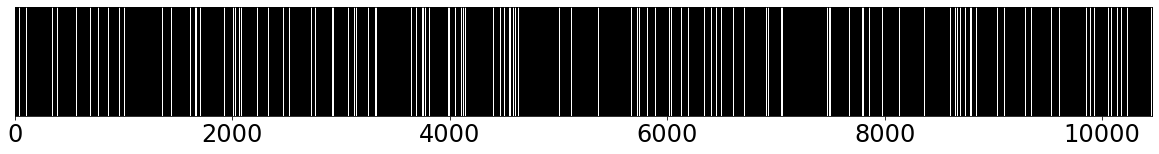

In [20]:
plt.figure(figsize = (30,2))
plt.grid(False)
whole_genes_array_withFAESelection_=np.tile(whole_genes_array_withFAESelection,(1000,1))
plt.yticks([]) 
plt.xticks(fontsize=24) 
colors = ['black', 'white']
cmap = mpl.colors.ListedColormap(colors)
plt.imshow(whole_genes_array_withFAESelection_, interpolation='nearest', cmap=cmap)
plt.show()

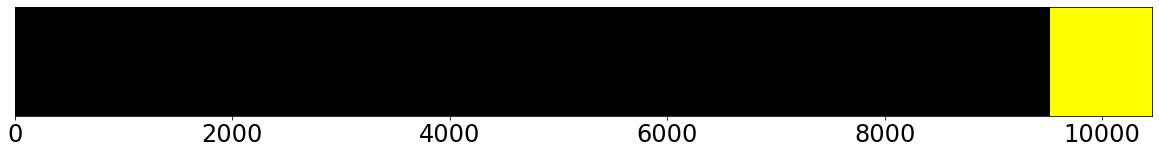

In [21]:
plt.figure(figsize = (30,2))
plt.grid(False)
whole_genes_array_withLandmarkgenes_=np.tile(whole_genes_array_withLandmarkgenes,(1000,1))
plt.yticks([]) 
plt.xticks(fontsize=24) 
colors = ['black', 'yellow']
cmap = mpl.colors.ListedColormap(colors)
plt.imshow(whole_genes_array_withLandmarkgenes_, interpolation='nearest', cmap=cmap)
plt.show()